# Working with Galaxy Zoo: 3D IFU masks
This notebook will walkthrough the vaious kinds of plots and analysis that can be made with the masks provided by GZ:3D.  Each galaxy has one `.fits` file containing the following information:

+ HDU 0: [image] SDSS cutout image presented to the user
+ HDU 1: [image] Pixel mask of clustering resutls for galaxy center(s). Each identified center is represented by a 2 sigma ellipse of the clustered points with the value of the pixels inside the ellipse equal to the number of points used belonging to that cluster.
+ HDU 2: [image] Pixel mask of clustering resutls for star(s). Each identified star is represented by a 2 sigma ellipse of the clustered points with the value of the pixels inside the ellipse equal to the number of points used belonging to that cluster.
+ HDU 3: [image] Pixel mask of spiral arm location(s).  The values for this maske are the number of polygons overlapping each pixel.
+ HDU 4: [image] Pixel mask of bar location.  The values for this maske are the number of polygons overlapping each pixel.
+ HDU 5: [table] Image metadata
+ HDU 6: [table] Center cluster data table in both pixel coordinates and RA-DEC.  The covariance values used to make the 2 sigma masks are also included.
+ HDU 7: [table] Star cluster data table in both pixel coordinates and RA-DEC.  The covariance values used to make the 2 sigma masks are also included.
+ HDU 8: [table] Raw center and star classifications provided in pixel coordinats.
+ HDU 9: [table] Raw spiral arm classifications provided in pixel coordinates.
+ HDU 10: [table] Raw bar classifications provided in pixel coordinates.

In addition to these `.fits` files the `gz3d_fits` class inside the `gz3d_fits.py` file provides methods useful to accessing and plotting these masks on data from Marvin.

This class will use Marvin in `local` mode with `download=True`, meaning it will download the spectra and maps files to your local `sas` directory as needed.

## File names
Each `.fits` file is named in the following way `<MaNGA ID>_<IFU size>_<Zooniverse subject id>.fits.gz`.  This ensures that each GZ:3D subject has a unique name.

## Metadata
The metadata for the full set of data can be found in the `manga_MPL5_metadata.fits` file.

## Loading a `.fits` file

In [1]:
import os
os.environ['SAS_BASE_DIR'] = '{0}/sas'.format(os.environ['HOME'])

In [2]:
from gz3d_fits import gz3d_fits

data = gz3d_fits('./1-167242_127_5679242.fits.gz')
data.get_bpt()
data.make_all_spaxel_masks()
data.get_mean_spectra(inv=True)

INFO: No release version set. Setting default to MPL-5
         cannot be found. Setting drpall to None.


## Making a maplotlib style
Just to have nicer defaults for the plots.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

style = {
    # Line styles
    'lines.linewidth': 1.5,
    'lines.antialiased': True,

    # Font
    'font.size': 16.0,

    # Axes
    'axes.linewidth': 1.5,
    'axes.titlesize': 'large',
    'axes.labelsize': 'large',

    # Ticks
    'xtick.major.size': 6,
    'xtick.minor.size': 4,
    'xtick.major.width': 1.5,
    'xtick.minor.width': 1.5,
    'xtick.major.pad': 6,
    'xtick.minor.pad': 6,
    'xtick.labelsize': 'medium',
    'xtick.direction': 'in',

    'ytick.major.size': 6,
    'ytick.minor.size': 4,
    'ytick.major.width': 1.5,
    'ytick.minor.width': 1.5,
    'ytick.major.pad': 6,
    'ytick.minor.pad': 6,
    'ytick.labelsize': 'medium',
    'ytick.direction': 'in',

    # Legend
    'legend.fancybox': True,
    'legend.fontsize': 'small',
    'legend.scatterpoints': 5,
    'legend.loc': 'best',

    # Figure
    'figure.figsize': [8, 6],
    'figure.titlesize': 'large',

    # Images
    'image.cmap': 'magma',
    'image.origin': 'upper',

    # Saving
    'savefig.bbox': 'tight',
    'savefig.format': 'png',
}

plt.style.use(style)

## Plotting the origianal image

When the images were created the hexagon size was incorret due to a bug in the cutout code.  As a result, the `get_hexagon` method takes the keyword `correct_hex` as either `True` or `False`.  The image in HDU 0 contains the incorrectly sized hexagon that was shown on the project.

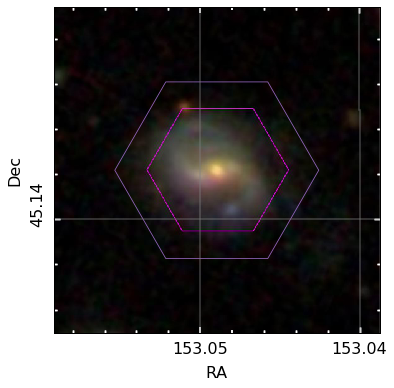

In [4]:
def set_up_axes(ax, color_grid='white', color_tick='white'):
    # extract the coordinates from the axes object
    ra = ax.coords['ra']
    dec = ax.coords['dec']
    # add axis labels
    ra.set_axislabel('RA')
    dec.set_axislabel('Dec')
    # rotate tick labels on dec
    dec.ticklabels.set_rotation(90)
    # add a coordinate grid to the image
    ax.coords.grid(color=color_grid, alpha=0.5, linestyle='solid', lw=1.5)
    for coord in [ra, dec]:
        # set the tick formats
        coord.set_major_formatter('d.dd')
        coord.set_ticks(color=color_tick)
        coord.display_minor_ticks(True)

fig = plt.figure(1)
ax = fig.add_subplot(111, projection=data.wcs)
set_up_axes(ax, color_grid='C7')
ax.add_patch(data.get_hexagon(correct_hex=True, edgecolor='C4'))
ax.imshow(data.image)

## Plotting the various masks

Next we can plot the center, star, bar, and sprial arm masks.  These masks are the same size as the image in HDU 0 (525x525).

Before plotting these maps we will create some helper functions the plot each of the masks as alpha-overlays on each other, and the color maps to go along with them.  We will also plot the theta=0 line as reference for later plots.

In [5]:
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import numpy as np
import astropy.wcs as wcs

def alpha_overlay(C_a, a_a, C_b, a_b=None):
    # Take a base color (C_a), an alpha map (a_a), and a backgroud image (C_b)
    # and overlay them.
    if a_b is None:
        a_b = np.ones(a_a.shape)
    c_a = np.array([a_a.T] * 3).T * C_a
    c_b = np.array([a_b.T] * 3).T * C_b
    c_out = c_a + ((1 - a_a.T) * c_b.T).T
    return c_out


def alpha_maps(maps, colors=None, vmin=0, vmax=15):
    # Take a list of color masks and base color values
    # and make an alpha-mask overlay image.
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    iter_cycle = iter(mpl.rcParams['axes.prop_cycle'])
    for mdx, m in enumerate(maps):
        if colors is None:
            c = next(iter_cycle)['color']
        else:
            c = colors[mdx]
        base_color = np.array(mpl.colors.to_rgb(c))
        norm_map = norm(m)
        if mdx == 0:
            background_color = np.ones(3)
        background_color = alpha_overlay(base_color, norm_map, background_color)
    return background_color


def make_alpha_bar(color, vmin=-1, vmax=15):
    # make a matplotlib color bar for a alpha maks of a single color
    # vmin of -1 to make lables line up correctly
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    a_a = norm(range(vmin, vmax))
    C_a = np.array(mpl.colors.to_rgb(color))
    new_cm = alpha_overlay(C_a, a_a, np.ones(3))
    return mpl.colors.ListedColormap(new_cm), norm


def make_alpha_color(count, color, vmin=1, vmax=15):
    # get the alpha-color for a given value
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    return mpl.colors.to_rgb(color) + (norm(count), )


def plot_alpha_bar(color, grid, ticks=[]):
    # plot the alpha color bar
    bar, norm = make_alpha_bar(color)
    ax_bar = plt.subplot(grid)
    cb = mpl.colorbar.ColorbarBase(ax_bar, cmap=bar, norm=norm, orientation='vertical', ticks=ticks)
    cb.outline.set_linewidth(0)
    return ax_bar, cb


def zero_theta_line(gz3d):
    phi = gz3d.maps.nsa['elpetro_phi']
    map_wcs = wcs.WCS(gz3d.maps['spx_ellcoo_elliptical_azimuth'].header, naxis=2)
    # get the center of the image
    # cx, cy = map_wcs.wcs_world2pix(ra, dec, 0)
    r_map = gz3d.maps['spx_ellcoo_elliptical_radius'].value
    cy, cx = map(np.mean, np.nonzero(np.isclose(r_map, 0, atol=1)))
    # get the max radius
    r = np.sqrt(cx**2 + cy**2)
    # get the end of the line
    x = r * np.sin(np.deg2rad(-phi)) + cx
    y = r * np.cos(np.deg2rad(-phi)) + cy
    # world coords
    ra_line, dec_line = map_wcs.wcs_pix2world([cx, x], [cy, y], 0)
    # image coords
    return gz3d.wcs.wcs_world2pix(ra_line, dec_line, 0)

With these helper function we can now plot the masks.  To align everthing nicely we will use `gridspec` for the subplots.

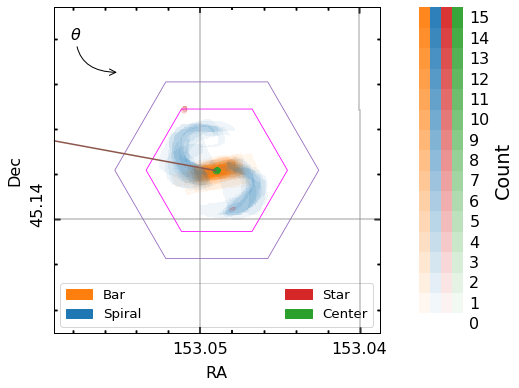

In [7]:
fig = plt.figure(2)

# make the subplot grids
gs = gridspec.GridSpec(1, 2, width_ratios=[0.9, 0.1], wspace=0.01)
gs_color_bars = gridspec.GridSpecFromSubplotSpec(1, 4, wspace=0, subplot_spec=gs[1])

# make the alpha overlay image
maps = [data.bar_mask, data.spiral_mask, data.star_mask, data.center_mask]
colors=['C1', 'C0', 'C3', 'C2']
all_mask = alpha_maps(maps, colors)

# plot the overlay image
ax1 = plt.subplot(gs[0], projection=data.wcs)
set_up_axes(ax1, color_grid='C7', color_tick='black')
ax1.imshow(all_mask)

# plot hexagons for reference
ax1.add_patch(data.get_hexagon())
ax1.add_patch(data.get_hexagon(correct_hex=True, edgecolor='C4'))

# plot center and star ellipses (to better define the ellipse shape)
center_ellip = data.get_center_ellipse_list()
for e, count in zip(center_ellip, data.center_clusters['count']):
    e.set_edgecolor(make_alpha_color(count, 'C2'))
    ax1.add_artist(e)
star_ellip = data.get_star_ellipse_list()
for e, count in zip(star_ellip, data.star_clusters['count']):
    e.set_edgecolor(make_alpha_color(count, 'C3'))
    ax1.add_artist(e)

# plot theta=0 line
x_theta, y_theta = zero_theta_line(data)
ax1.plot(x_theta, y_theta, 'C5')
ax1.annotate(r'$\theta$', xy=(0.2, 0.8), xytext=(0.05, 0.9), arrowprops={'arrowstyle': '->', 'connectionstyle': 'angle3'}, xycoords='axes fraction', textcoords='axes fraction')

# make a legend
bar_patch = mpl.patches.Patch(color=colors[0], label='Bar')
spiral_patch = mpl.patches.Patch(color=colors[1], label='Spiral')
star_patch = mpl.patches.Patch(color=colors[2], label='Star')
center_patch = mpl.patches.Patch(color=colors[3], label='Center')
plt.legend(handles=[bar_patch, spiral_patch, star_patch, center_patch], ncol=2, loc='lower center', mode='expand')

# make colorbars
ax_bar, cb_bar = plot_alpha_bar(colors[0], gs_color_bars[0])
ax_spiral, cb_spiral = plot_alpha_bar(colors[1], gs_color_bars[1])
ax_star, cb_star = plot_alpha_bar(colors[2], gs_color_bars[2])
ax_center, cb_center = plot_alpha_bar(colors[3], gs_color_bars[3])
ax_center.tick_params(axis=u'both', which=u'both', length=0)
tick_labels = np.arange(0, 16)
tick_locs = tick_labels - 0.5
cb_center.set_ticks(tick_locs)
cb_center.set_ticklabels(tick_labels)
cb_center.set_label('Count')

## Use the maps to plot spaxel map properties as function of r and theta

These masks can be used to pull out spectral line information as function of r and theta for each of the identified features.

For these plots we will also color code the spaxel data with the correct alpha-color from the masks.  The helper function `plot_alpha_scatter` does this.

(0, 360)

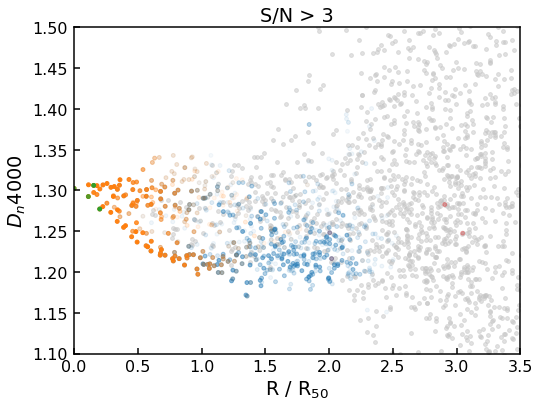

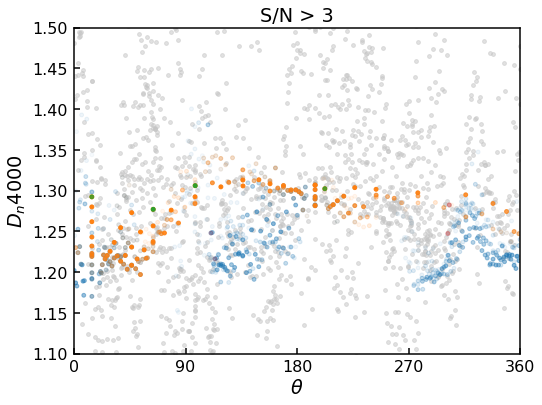

In [8]:
def plot_alpha_scatter(x, y, mask, color, ax, snr=None, sf_mask=None, value=True, **kwargs):
    idx = mask > 0
    if value:
        idx = idx & (y.value > 0)
    if (value) and (snr is not None):
        idx = idx & (y.snr > snr)
    if sf_mask is not None:
        idx = idx & sf_mask
    c = mpl.colors.to_rgb(color)
    c_a = np.array([c + (i, ) for i in mask[idx] / 15])
    c_a[c_a > 1] = 1
    if value:
        return ax.scatter(x[idx], y.value[idx], c=c_a, edgecolor=c_a, **kwargs)
    else:
        return ax.scatter(x[idx], y[idx], c=c_a, edgecolor=c_a, **kwargs)

# the radius plot for D_n4000
fig3 = plt.figure(3)
ax3 = plt.gca()
snr = 3
s = 15
r = data.maps['spx_ellcoo_elliptical_radius'].value
r_50 = data.maps.nsa['elpetro_th50_r']
r_plot = r / r_50
line = data.maps['specindex_dn4000']
# mask of spaxels not in a user drawn map
odx = (data.other_mask_spaxel > 0) & (line.value > 0) & (line.snr > snr)
ax3.scatter(r_plot[odx], line.value[odx], c='#c5c5c5', edgecolor='#c5c5c5', s=s, alpha=0.5)
plot_alpha_scatter(r_plot, line, data.spiral_mask_spaxel, 'C0', ax3, s=s, snr=snr)
plot_alpha_scatter(r_plot, line, data.bar_mask_spaxel, 'C1', ax3, s=s, snr=snr)
plot_alpha_scatter(r_plot, line, data.star_mask_spaxel, 'C3', ax3, s=s, snr=snr)
plot_alpha_scatter(r_plot, line, data.center_mask_spaxel, 'C2', ax3, s=s, snr=snr)
ax3.set_title('S/N > {0}'.format(snr))
ax3.set_ylabel(r'$D_{n}4000$')
ax3.set_xlabel(r'R / R$_{50}$')
ax3.set_ylim(1.1, 1.5)
ax3.set_xlim(0, 3.5)

# the theta plot for D_n4000
fig4 = plt.figure(4)
ax4 = plt.gca()
theta = data.maps['spx_ellcoo_elliptical_azimuth'].value
ax4.scatter(theta[odx], line.value[odx], c='#c5c5c5', edgecolor='#c5c5c5', s=s, alpha=0.5)
plot_alpha_scatter(theta, line, data.spiral_mask_spaxel, 'C0', ax4, s=s, snr=snr)
plot_alpha_scatter(theta, line, data.bar_mask_spaxel, 'C1', ax4, s=s, snr=snr)
plot_alpha_scatter(theta, line, data.star_mask_spaxel, 'C3', ax4, s=s, snr=snr)
plot_alpha_scatter(theta, line, data.center_mask_spaxel, 'C2', ax4, s=s, snr=snr)
ax4.set_xticks([0, 90, 180, 270, 360])
ax4.set_title('S/N > {0}'.format(snr))
ax4.set_ylabel(r'$D_{n}4000$')
ax4.set_xlabel(r'$\theta$')
ax4.set_ylim(1.1, 1.5)
ax4.set_xlim(0, 360)

## Average spectra

We can also make the average spectra for all spaxels within each mask using the `get_mean_spectra` method (see first cell).  The `inv` keyword indicates if the "inverse mask" averages should be computed as well (i.e. average not-bar spectra in addtion the the average bar spectra).

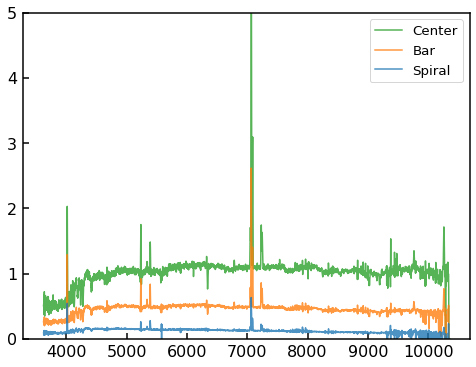

In [9]:
fig5 = plt.figure(5)
ax5 = plt.gca()
ax5.plot(data.mean_center.wavelength, data.mean_center.flux, label='Center', color='C2', alpha=0.8)
ax5.plot(data.mean_bar.wavelength, data.mean_bar.flux, label='Bar', color='C1', alpha=0.8)
ax5.plot(data.mean_spiral.wavelength, data.mean_spiral.flux, label='Spiral', color='C0', alpha=0.8)
ax5.set_ylim(0, 5)
ax5.legend()

With the inverse average specta we can also plot the difference specta (i.e. `<Bar spectra> - <Not Bar spectra>`)

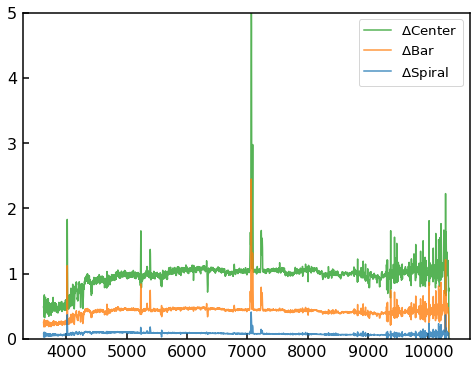

In [10]:
dif_center = data.mean_center - data.mean_not_center
dif_bar = data.mean_bar - data.mean_not_bar
dif_spiral = data.mean_spiral - data.mean_not_spiral

fig6 = plt.figure(6)
ax6 = plt.gca()
ax6.plot(dif_center.wavelength, dif_center.flux, label=r'$\Delta$Center', color='C2', alpha=0.8)
ax6.plot(dif_bar.wavelength, dif_bar.flux, label=r'$\Delta$Bar', color='C1', alpha=0.8)
ax6.plot(dif_spiral.wavelength, dif_spiral.flux, label=r'$\Delta$Spiral', color='C0', alpha=0.8)
ax6.set_ylim(0, 5)
ax6.legend()

## BPT diagrams
We can also make BPT diagrams color coded by mask type. The `get_bpt` method is used to create the various BPT maps with a `snr_min` value (3 by default, see first cell).

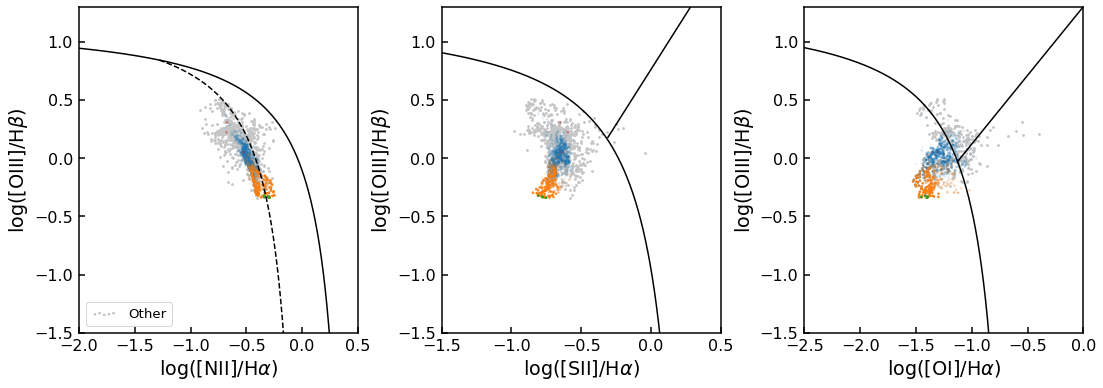

In [11]:
import marvin.utils.dap.bpt as bpt


def plot_bpt_boundry(axs):
    # Plots the classification boundary lines
    xx_sf_nii = np.linspace(-1.281, 0.045, int(1e4))
    xx_sf_sii = np.linspace(-2, 0.315, int(1e4))
    xx_sf_oi = np.linspace(-2.5, -0.7, int(1e4))
    xx_comp_nii = np.linspace(-2, 0.4, int(1e4))
    xx_agn_sii = np.array([-0.308, 1.0])
    xx_agn_oi = np.array([-1.12, 0.5])
    # xlims = [ax.get_xlim() for ax in axs]
    # ylims = [ax.get_ylim() for ax in axs]
    xlims = [(-2, 0.5), (-1.5, 0.5), (-2.5, 0.0)]
    ylims = [(-1.5, 1.3), (-1.5, 1.3), (-1.5, 1.3)]
    xlabels = [r'log([NII]/H$\alpha$)', r'log([SII]/H$\alpha$)', r'log([OI]/H$\alpha$)']
    axs[0].plot(xx_sf_nii, bpt.kewley_sf_nii(xx_sf_nii), 'k--', zorder=90)
    axs[0].plot(xx_comp_nii, bpt.kewley_comp_nii(xx_comp_nii), 'k-', zorder=90)
    axs[1].plot(xx_sf_sii, bpt.kewley_sf_sii(xx_sf_sii), 'k-', zorder=90)
    axs[1].plot(xx_agn_sii, bpt.kewley_agn_sii(xx_agn_sii), 'k-', zorder=80)
    axs[2].plot(xx_sf_oi, bpt.kewley_sf_oi(xx_sf_oi), 'k-', zorder=90)
    axs[2].plot(xx_agn_oi, bpt.kewley_agn_oi(xx_agn_oi), 'k-', zorder=80)
    for ax, xlim, ylim, xlabel in zip(axs, xlims, ylims, xlabels):
        ax.set_ylabel(r'log([OIII]/H$\beta$)')
        ax.set_xlabel(xlabel)
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
    axs[0].legend(loc=3)

    
def plot_bpt_alpha(gz3d, ax, bpt_kind, **kwargs):
    y = gz3d.log_oiii_hb
    x = getattr(gz3d, bpt_kind)
    mdx = ~(y.mask | x.mask)
    s = kwargs.pop('s', 8)
    odx = mdx & (gz3d.other_mask_spaxel > 0)
    ax.scatter(x[odx], y[odx], c='#c5c5c5', edgecolor='#c5c5c5', s=s, label='Other', **kwargs)
    plot_alpha_scatter(x, y, gz3d.spiral_mask_spaxel, 'C0', ax, s=s, sf_mask=mdx, snr=None, value=False, **kwargs)
    plot_alpha_scatter(x, y, gz3d.bar_mask_spaxel, 'C1', ax, s=s, sf_mask=mdx, snr=None, value=False, **kwargs)
    plot_alpha_scatter(x, y, gz3d.star_mask_spaxel, 'C3', ax, s=s, sf_mask=mdx, snr=None, value=False, **kwargs)
    plot_alpha_scatter(x, y, gz3d.center_mask_spaxel, 'C2', ax, s=s, sf_mask=mdx, snr=None, value=False, **kwargs)


fig7 = plt.figure(7, figsize=(18, 6))
gs = gridspec.GridSpec(1, 3, wspace=0.3)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
plot_bpt_alpha(data, ax0, 'log_nii_ha', s=3)
plot_bpt_alpha(data, ax1, 'log_sii_ha', s=3)
plot_bpt_alpha(data, ax2, 'log_oi_ha', s=3)
plot_bpt_boundry([ax0, ax1, ax2])